## Implementation of [Hierarchical Causal Models](https://arxiv.org/abs/2401.05330) (Weinstein and Blei, 2024)

In [1]:
from pathlib import Path

from IPython.display import SVG
from matplotlib_inline.backend_inline import set_matplotlib_formats

from y0.algorithm.identify import identify_outcomes
from y0.dsl import A, Y
from y0.hierarchical import (
    HierarchicalCausalModel,
    QVariable,
    augment_collapsed_model,
    augment_from_mechanism,
    marginalize_augmented_model,
)
from y0.examples import hierarchical as hcme

set_matplotlib_formats("svg")

image_dir = Path(".").parent.joinpath("images", "hierarchical")
image_dir.mkdir(exist_ok=True)


def _draw(hcm, name: str) -> SVG:
    graph = hcm.to_pygraphviz()
    graph.layout("dot")
    svg = graph.draw(format="svg:cairo").decode("utf8")
    return SVG(svg)


Qy = QVariable.parse_str("Q_Y")
Qa = QVariable.parse_str("Q_A")
Qax = QVariable.parse_str("Q_{A|X}")

# Figure 2 

## Confounder

Create the hierarchical causal model (HCM) in pygraphviz

Figure 2 (a)

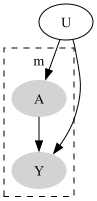

In [2]:
confounder_hcm = hcme.confounder_hcm

_draw(confounder_hcm, "confounder_HCM.svg")

Create the collapsed model as an NxMixedGraph  
(note that the paper displays latent variables but here we use semiMarkov graphs with latent variable connections represented by undirected edges)

Figure 2 (c)

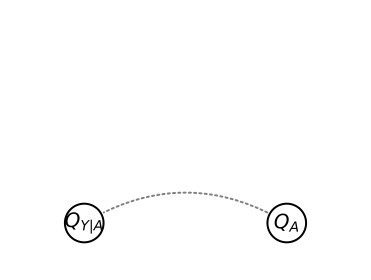

In [3]:
confounder_collapsed = confounder_hcm.to_admg()
confounder_collapsed.draw()

Augment the collapsed model with new $Q_y$ variable and its mechanism $Q_y = m(Q_{y|a}, Q_a)$ from $\Pr(Y) = \Pr(Y | A) \Pr(A)$

Figure 2 (d)

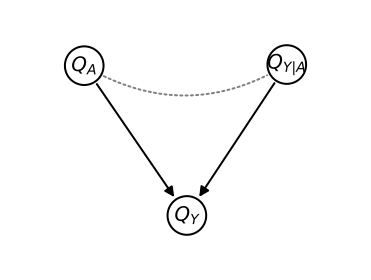

In [4]:
subg = confounder_hcm.get_subunit_graph()
confounder_augmented = augment_collapsed_model(confounder_collapsed, subg, "Q_Y")
confounder_augmented.draw(prog="neato")

In [5]:
identify_outcomes(outcomes={Qy}, treatments={Qa}, graph=confounder_augmented)

Sum[QVariable(Y, ['A'])](P(QVariable(Y, []) | QVariable(A, []), QVariable(Y, ['A'])) * Sum[QVariable(A, []), QVariable(Y, [])](P(QVariable(A, []), QVariable(Y, ['A']), QVariable(Y, []))))

## Confounder and Interference

Create the HCM in pygraphviz

Figure 2 (e)

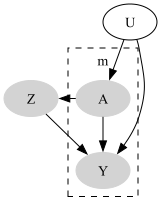

In [6]:
conf_and_int_hcm = hcme.get_confounder_interference_hcm()

_draw(conf_and_int_hcm, "confounder_and_interference_HCM.svg")

Create the collapsed model as an NxMixed Graph

Figure 2 (g)

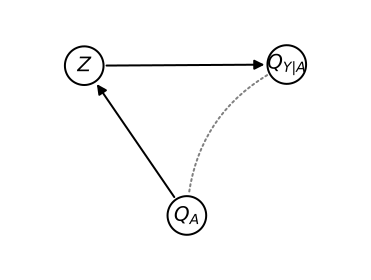

In [7]:
conf_and_int_collapsed = conf_and_int_hcm.to_admg()
conf_and_int_collapsed.draw(prog="neato")

Augment the collapsed model with new variable $Q_y$ and its mechanism $Q_y = m(Q_{y|a}, Q_a)$ from $\Pr(Y) = \Pr(Y|A) \Pr(A)$

Figure 2 (h)

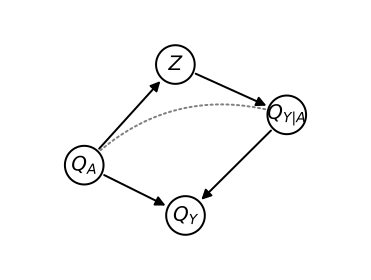

In [8]:
conf_and_int_augmented = augment_collapsed_model(
    conf_and_int_collapsed, conf_and_int_hcm.get_subunit_graph(), "Q_Y"
)
conf_and_int_augmented.draw(prog="dot")

In [9]:
identify_outcomes(
    graph=conf_and_int_augmented,
    treatments=Qa,
    outcomes=Qy
)

Sum[QVariable(Y, ['A']), Z](P(QVariable(Y, []) | QVariable(A, []), QVariable(Y, ['A']), Z) * P(Z | QVariable(A, [])) * Sum[QVariable(A, [])](P(QVariable(A, [])) * P(QVariable(Y, ['A']) | QVariable(A, []), Z)))

## Instrument

Create the HCM in pygraphviz

Figure 2 (i)

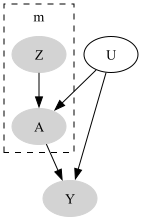

In [10]:
instrument_hcm = hcme.get_instrument_hcm()

_draw(instrument_hcm, "instrument_HCM.svg")

Create the collapsed model as an NxMixedGraph

Figure 2 (k)

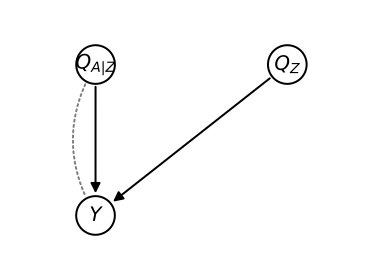

In [11]:
instrument_collapsed = instrument_hcm.to_admg()
instrument_collapsed.draw()

Augment the collapsed model with new variable $Q_a$ and its mechanism $Q_a = m(Q_{a|z}, Q_z)$ from $\Pr(A) = \Pr(A|Z) \Pr(Z)$

Figure A2

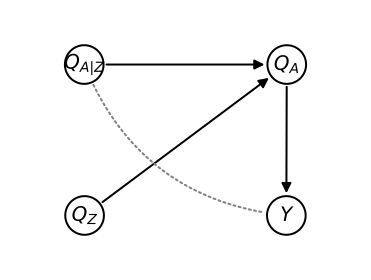

In [12]:
instrument_augmented = augment_collapsed_model(
    instrument_collapsed, instrument_hcm.get_subunit_graph(), "Q_A"
)
instrument_augmented.draw()

In [13]:
identify_outcomes(outcomes={Y}, treatments={Qa}, graph=instrument_augmented)

Sum[QVariable(A, ['Z'])](P(QVariable(A, ['Z'])) * P(Y | QVariable(A, ['Z']), QVariable(A, []), QVariable(Z, [])))

Marginalize out the $Q_z$ variable to ensure subunit positivity

Figure 2 (d)

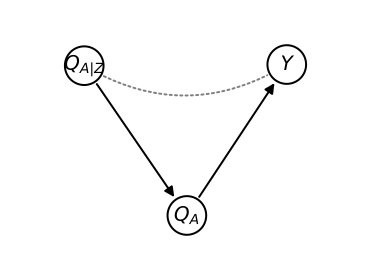

In [14]:
instrument_marg = marginalize_augmented_model(
    instrument_augmented, QVariable.parse_str("Q_A"), [QVariable.parse_str("Q_Z")]
)
instrument_marg.draw(prog="neato")

In [15]:
identify_outcomes(
    graph=instrument_marg,
    treatments=Qa,
    outcomes=Y,
)

Sum[QVariable(A, ['Z'])](P(QVariable(A, ['Z'])) * P(Y | QVariable(A, ['Z']), QVariable(A, [])))

# Figure A3

(a)

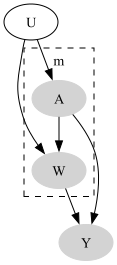

In [16]:
HCM = HierarchicalCausalModel.from_lists(
    observed_subunits=["A", "W"],
    observed_units=["Y"],
    unobserved_units=["U"],
    edges=[("U", "A"), ("A", "Y"), ("A", "W"), ("U", "W"), ("W", "Y")],
)

_draw(HCM, "A3_a.svg")

(b)

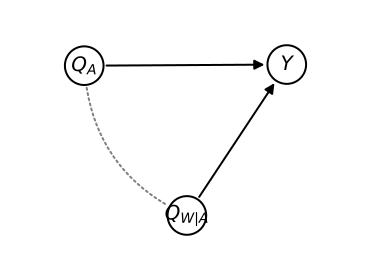

In [17]:
col = HCM.to_admg()
col.draw(prog="neato")

In [18]:
identify_outcomes(outcomes={Y}, treatments={Qa}, graph=col)

Sum[QVariable(W, ['A'])](P(Y | QVariable(A, []), QVariable(W, ['A'])) * Sum[QVariable(A, []), Y](P(QVariable(A, []), QVariable(W, ['A']), Y)))

(c)

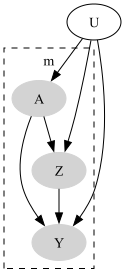

In [19]:
HCM = HierarchicalCausalModel.from_lists(
    observed_subunits=["A", "Y", "Z"],
    unobserved_units=["U"],
    edges=[("U", "A"), ("A", "Y"), ("A", "Z"), ("Z", "Y"), ("U", "Z"), ("U", "Y")],
)

_draw(HCM, "A3_c.svg")

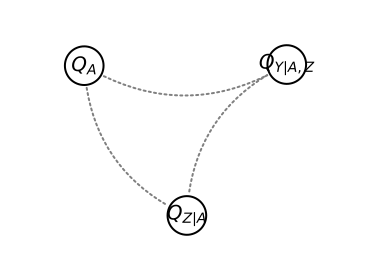

In [20]:
col = HCM.to_admg()
col.draw(prog="neato")

(d)

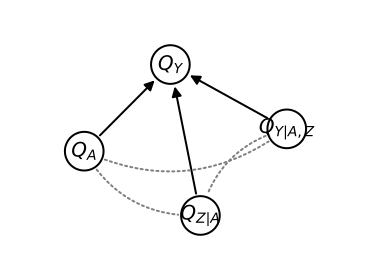

In [21]:
aug = augment_collapsed_model(col, HCM.get_subunit_graph(), "Q_Y")
aug.draw(prog="neato")

In [22]:
identify_outcomes(graph=aug, treatments=Qa, outcomes=Qy)

Sum[QVariable(Y, ['A', 'Z']), QVariable(Z, ['A'])](P(QVariable(Y, []) | QVariable(A, []), QVariable(Y, ['A', 'Z']), QVariable(Z, ['A'])) * Sum[QVariable(A, []), QVariable(Y, [])](P(QVariable(A, []), QVariable(Y, ['A', 'Z']), QVariable(Y, []), QVariable(Z, ['A']))))

(e)

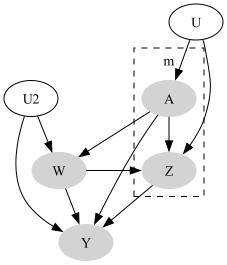

In [23]:
HCM = HierarchicalCausalModel.from_lists(
    observed_subunits=["A", "Z"],
    observed_units=["W", "Y"],
    unobserved_units=["U", "U2"],
    edges=[
        ("U", "A"),
        ("U", "Z"),
        ("A", "Z"),
        ("A", "W"),
        ("A", "Y"),
        ("W", "Y"),
        ("W", "Z"),
        ("Z", "Y"),
        ("U2", "W"),
        ("U2", "Y"),
    ],
)

_draw(HCM, "A3_e.svg")

(f)

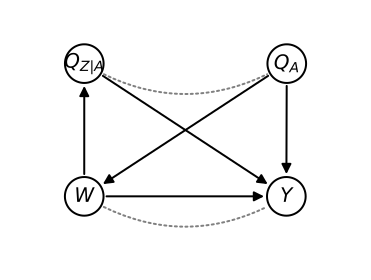

In [24]:
col = HCM.to_admg()
col.draw()

In [25]:
identify_outcomes(outcomes={Y}, treatments={Qa}, graph=col)

Sum[W, QVariable(Z, ['A'])](Sum[QVariable(A, [])](P(QVariable(A, [])) * P(QVariable(Z, ['A']) | QVariable(A, []), W)) * P(W | QVariable(A, [])) * P(Y | QVariable(A, []), W, QVariable(Z, ['A'])))

(g)

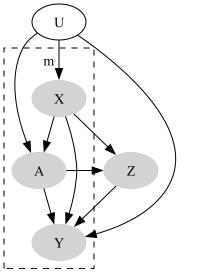

In [26]:
HCM = HierarchicalCausalModel.from_lists(
    observed_subunits=["A", "X", "Y"],
    observed_units=["Z"],
    unobserved_units=["U"],
    edges=[
        ("U", "A"),
        ("U", "X"),
        ("U", "Y"),
        ("A", "Z"),
        ("A", "Y"),
        ("Z", "Y"),
        ("X", "A"),
        ("X", "Y"),
        ("X", "Z"),
    ],
)

_draw(HCM, "A3_g.svg")

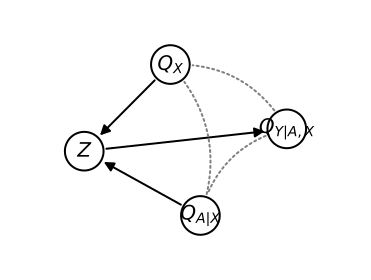

In [27]:
col = HCM.to_admg()
col.draw(prog="neato")

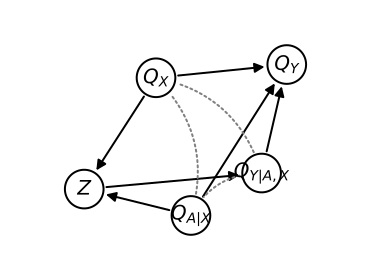

In [28]:
aug = augment_collapsed_model(col, HCM.get_subunit_graph(), "Q_Y")
aug.draw(prog="neato")

In [29]:
identify_outcomes(outcomes={Qy}, treatments={Qax}, graph=aug)

Sum[QVariable(X, []), QVariable(Y, ['A', 'X']), Z](P(QVariable(Y, []) | QVariable(A, ['X']), QVariable(X, []), QVariable(Y, ['A', 'X']), Z) * P(Z | QVariable(A, ['X']), QVariable(X, [])) * Sum[QVariable(A, ['X'])](P(QVariable(A, ['X'])) * P(QVariable(X, []) | QVariable(A, ['X'])) * P(QVariable(Y, ['A', 'X']) | QVariable(A, ['X']), QVariable(X, []), Z)))

(j)

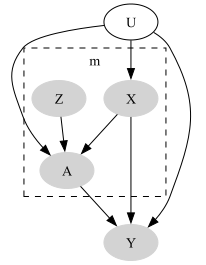

In [30]:
HCM = HierarchicalCausalModel.from_lists(
    observed_subunits=["A", "X", "Z"],
    observed_units=["Y"],
    unobserved_units=["U"],
    edges=[("U", "A"), ("U", "X"), ("U", "Y"), ("Z", "A"), ("A", "Y"), ("X", "Y"), ("X", "A")],
)
_draw(HCM, "A3_j.svg")

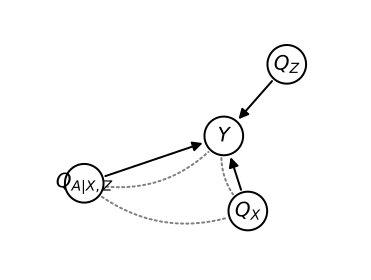

In [31]:
col = HCM.to_admg()
col.draw(prog="neato")

(k)

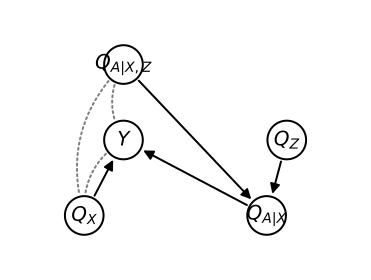

In [32]:
aug = augment_from_mechanism(
    col,
    QVariable.parse_str("Q_{A|X}"),
    [QVariable.parse_str("Q_Z"), QVariable.parse_str("Q_{A|X,Z}")],
)
aug.draw(prog="dot")

(l)

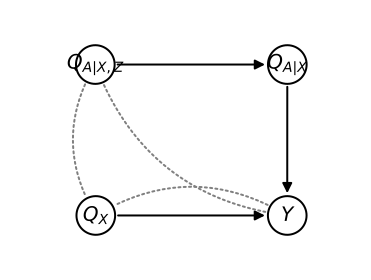

In [33]:
marg = marginalize_augmented_model(
    aug, QVariable.parse_str("Q_{A|X}"), [QVariable.parse_str("Q_Z")]
)
marg.draw()

In [34]:
identify_outcomes(outcomes={Y}, treatments={Qa}, graph=marg)

Sum[QVariable(A, ['X']), QVariable(A, ['X', 'Z']), QVariable(X, [])](P(QVariable(A, ['X']) | QVariable(A, ['X', 'Z'])) * P(QVariable(A, ['X', 'Z'])) * P(QVariable(X, []) | QVariable(A, ['X', 'Z'])) * P(Y | QVariable(A, ['X']), QVariable(A, ['X', 'Z']), QVariable(X, [])))

(m)

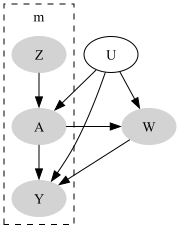

In [35]:
HCM = HierarchicalCausalModel.from_lists(
    observed_subunits=["A", "Y", "Z"],
    observed_units=["W"],
    unobserved_units=["U"],
    edges=[("U", "A"), ("U", "W"), ("U", "Y"), ("A", "W"), ("A", "Y"), ("W", "Y"), ("Z", "A")],
)

_draw(HCM, "A3_m.svg")

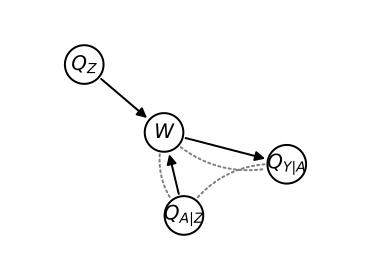

In [36]:
col = HCM.to_admg()
col.draw(prog="neato")

(n) two ways

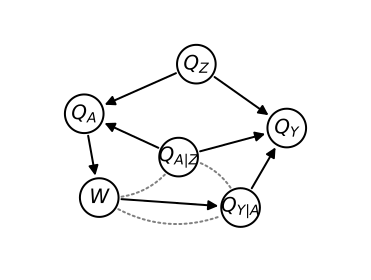

In [37]:
subg = HCM.get_subunit_graph()
aug1 = augment_collapsed_model(col, subg, "Q_A")
aug2 = augment_collapsed_model(aug1, subg, "Q_Y")
aug2.draw(prog="neato")

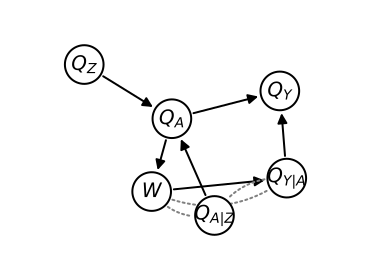

In [38]:
subg = HCM.get_subunit_graph()
aug1 = augment_collapsed_model(col, subg, "Q_Y")
aug2 = augment_collapsed_model(aug1, subg, "Q_A")
aug2.draw(prog="neato")

(o)

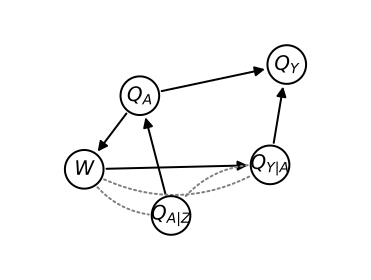

In [39]:
marg = marginalize_augmented_model(aug2, QVariable.parse_str("Q_A"), [QVariable.parse_str("Q_Z")])
marg.draw(prog="neato")

In [40]:
identify_outcomes(outcomes={Qy}, treatments={Qa}, graph=marg)

Sum[W, QVariable(Y, ['A'])](P(QVariable(Y, []) | QVariable(A, ['Z']), QVariable(A, []), W, QVariable(Y, ['A'])) * Sum[QVariable(A, ['Z'])](P(QVariable(A, ['Z'])) * P(W | QVariable(A, ['Z']), QVariable(A, [])) * P(QVariable(Y, ['A']) | QVariable(A, ['Z']), QVariable(A, []), W)))

(p)

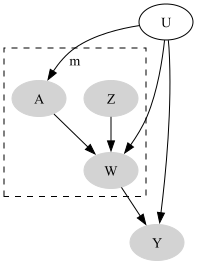

In [41]:
HCM = HierarchicalCausalModel.from_lists(
    observed_subunits=["A", "W", "Z"],
    observed_units=["Y"],
    unobserved_units=["U"],
    edges=[
        ("U", "A"),
        ("U", "W"),
        ("U", "Y"),
        ("A", "W"),
        ("Z", "W"),
        ("W", "Y"),
    ],
)

_draw(HCM, "A3_p.svg")

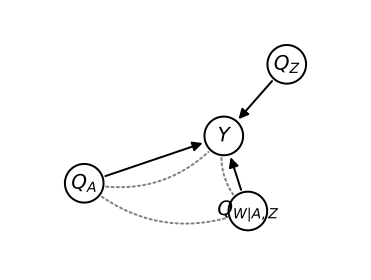

In [42]:
col = HCM.to_admg()
col.draw(prog="neato")

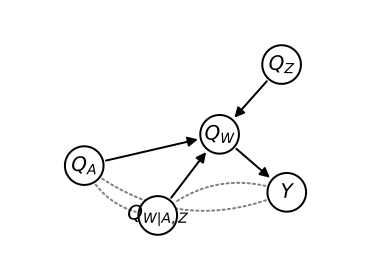

In [43]:
aug = augment_collapsed_model(col, HCM.get_subunit_graph(), "Q_W")
aug.draw(prog="neato")

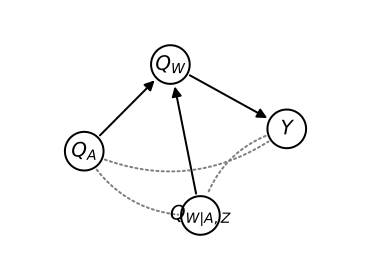

In [44]:
marg = marginalize_augmented_model(aug, QVariable.parse_str("Q_W"), [QVariable.parse_str("Q_Z")])
marg.draw(prog="neato")

In [45]:
identify_outcomes(outcomes={Y}, treatments={Qa}, graph=marg)

Sum[QVariable(W, ['A', 'Z']), QVariable(W, [])](P(QVariable(W, []) | QVariable(A, []), QVariable(W, ['A', 'Z'])) * Sum[QVariable(A, [])](P(QVariable(A, []) | QVariable(W, ['A', 'Z'])) * P(QVariable(W, ['A', 'Z'])) * P(Y | QVariable(A, []), QVariable(W, ['A', 'Z']), QVariable(W, []))))

## Figure A4

(a)

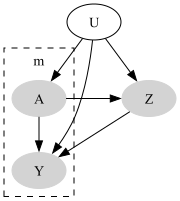

In [46]:
HCM = HierarchicalCausalModel.from_lists(
    observed_subunits=[
        "A",
        "Y",
    ],
    observed_units=["Z"],
    unobserved_units=["U"],
    edges=[
        ("U", "A"),
        ("U", "Z"),
        ("U", "Y"),
        ("A", "Y"),
        ("Z", "Y"),
        ("A", "Z"),
    ],
)

_draw(HCM, "A4_a.svg")

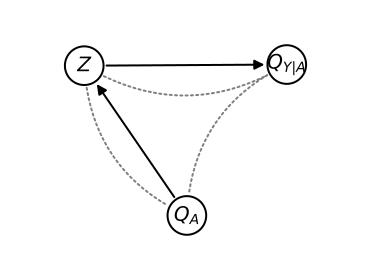

In [47]:
col = HCM.to_admg()
col.draw(prog="neato")

(b)

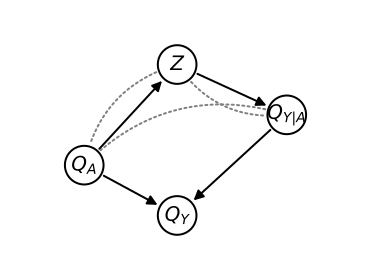

In [48]:
aug = augment_collapsed_model(col, HCM.get_subunit_graph(), "Q_Y")
aug.draw(prog="dot")

In [49]:
identify_outcomes(outcomes={Qy}, treatments={Qa}, graph=aug) is None

True

(c)

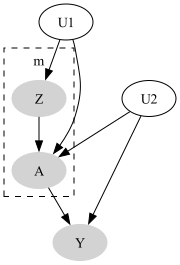

In [50]:
HCM = HierarchicalCausalModel.from_lists(
    observed_subunits=["A", "Z"],
    observed_units=["Y"],
    unobserved_units=["U1", "U2"],
    edges=[
        ("U1", "A"),
        ("U1", "Z"),
        ("U2", "A"),
        ("U2", "Y"),
        ("A", "Y"),
        ("Z", "A"),
    ],
)

_draw(HCM, "A4_c.svg")

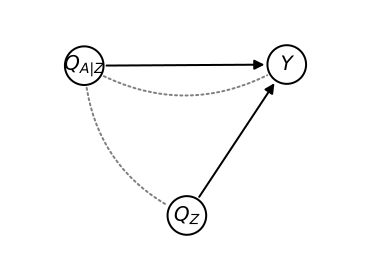

In [51]:
col = HCM.to_admg()
col.draw(prog="neato")

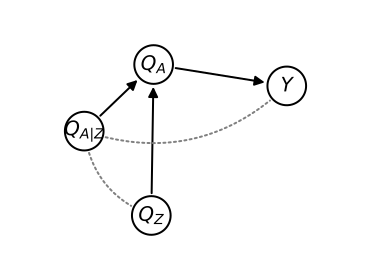

In [52]:
aug = augment_collapsed_model(col, HCM.get_subunit_graph(), "Q_A")
aug.draw(prog="neato")

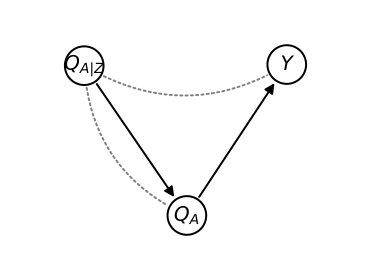

In [53]:
marg = marginalize_augmented_model(aug, QVariable.parse_str("Q_A"), [QVariable.parse_str("Q_Z")])
marg.draw(prog="neato")

In [54]:
identify_outcomes(outcomes={Y}, treatments={Qa}, graph=marg) is None

True

(f)

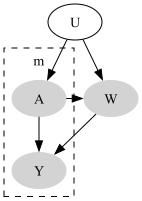

In [55]:
HCM = HierarchicalCausalModel.from_lists(
    observed_subunits=["A", "Y"],
    observed_units=["W"],
    unobserved_units=["U"],
    edges=[
        ("U", "A"),
        ("U", "W"),
        ("A", "W"),
        ("A", "Y"),
        ("W", "Y"),
    ],
)

_draw(HCM, "A4_f.svg")

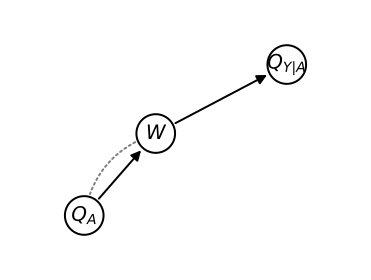

In [56]:
col = HCM.to_admg()
col.draw(prog="neato")

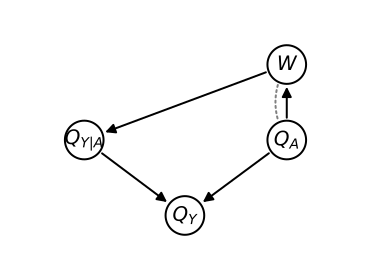

In [57]:
aug = augment_collapsed_model(col, HCM.get_subunit_graph(), "Q_Y")
aug.draw(prog="dot")

In [58]:
identify_outcomes(outcomes={Qy}, treatments={Qa}, graph=aug) is None

True

(h)

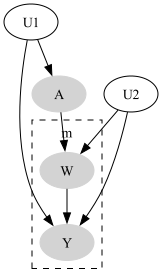

In [59]:
HCM = HierarchicalCausalModel.from_lists(
    observed_subunits=["W", "Y"],
    observed_units=["A"],
    unobserved_units=["U1", "U2"],
    edges=[
        ("U1", "A"),
        ("U1", "Y"),
        ("U2", "W"),
        ("U2", "Y"),
        ("A", "W"),
        ("W", "Y"),
    ],
)
_draw(HCM, "A4_h.svg")

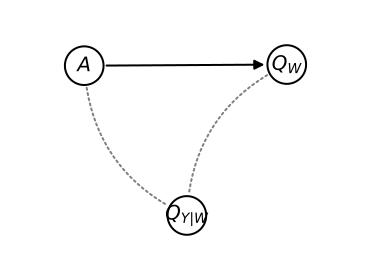

In [60]:
col = HCM.to_admg()
col.draw(prog="neato")

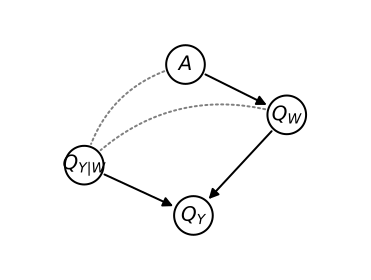

In [61]:
aug = augment_collapsed_model(col, HCM.get_subunit_graph(), "Q_Y")
aug.draw(prog="dot")

In [62]:
identify_outcomes(outcomes={Qy}, treatments={A}, graph=aug) is None

True